In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
from brokenaxes import brokenaxes  
import matplotlib.patches as patches
from scipy import stats  

In [2]:
base_path = "../../data/bayesian_inference/raw/traces/"
models = ["mixtral", "dm", "gpt"]

params = ['alpha', 'tau', 'beta_t', 'b0', 'b1', 'b2', 'beta_a', 'a', 'beta_c', 'sigma0', 'gamma', 'eps']

param_titles = ['Interaction strength', 'Interaction decay\ntime scale', 'Topic bias strength',
                 'Climate topic attractor', 'AI topic attractor', 'Wealth topic attractor',
                 'Agreement bias strength', 'Agreement bias attractor', 'Anchoring bias strength',
                 'Baseline std.', 'Opinion shift\ncontribution to std.',
                   'Uncertainty\ncontribution to std.']

param_labels = [r'$\alpha_\text{interact}$', r'$\tau$', r'$\beta_{\text{topic}}$', r'$b_{\text{climate}}$', r'$b_{\text{AI}}$', r'$b_{\text{wealth}}$',
                r'$\beta_{\text{agree}}$', r'$b_{\text{agree}}$', r'$\beta_{\text{anchor}}$', 
                r'$\sigma_0$', r'$\gamma$', r'$\epsilon$']


llms = ["mixtral", "dm", "gpt"]
llm_labels = ["Mixtral-8x7b", "DolphinMixtral", "GPT-4o-mini"]

# Data
posterior = {}

# Loop through LLMs
for i, llm in enumerate(llms):  # llms = ["LLM 1", "LLM 2", "LLM 3"]
    posterior[llm] = {}
    trace = az.from_netcdf(base_path + "full_model_trace_" + llm + "_all.nc")

    for param in params:

        if param=="b0":
            posterior[llm][param] = trace.posterior["b"].values[...,0].flatten()

        elif param=="b1":
            posterior[llm][param] = trace.posterior["b"].values[...,1].flatten()
        
        elif param=="b2":
            posterior[llm][param] = trace.posterior["b"].values[...,2].flatten()
        
        else:
            posterior[llm][param] = trace.posterior[param].values.flatten()

new_order = [0, 1, 6, 7, 2, 3, 4, 5, 8, 9, 10, 11]

# Reorder the parameters
params = [params[i] for i in new_order]
param_titles = [param_titles[i] for i in new_order]
param_labels = [param_labels[i] for i in new_order]

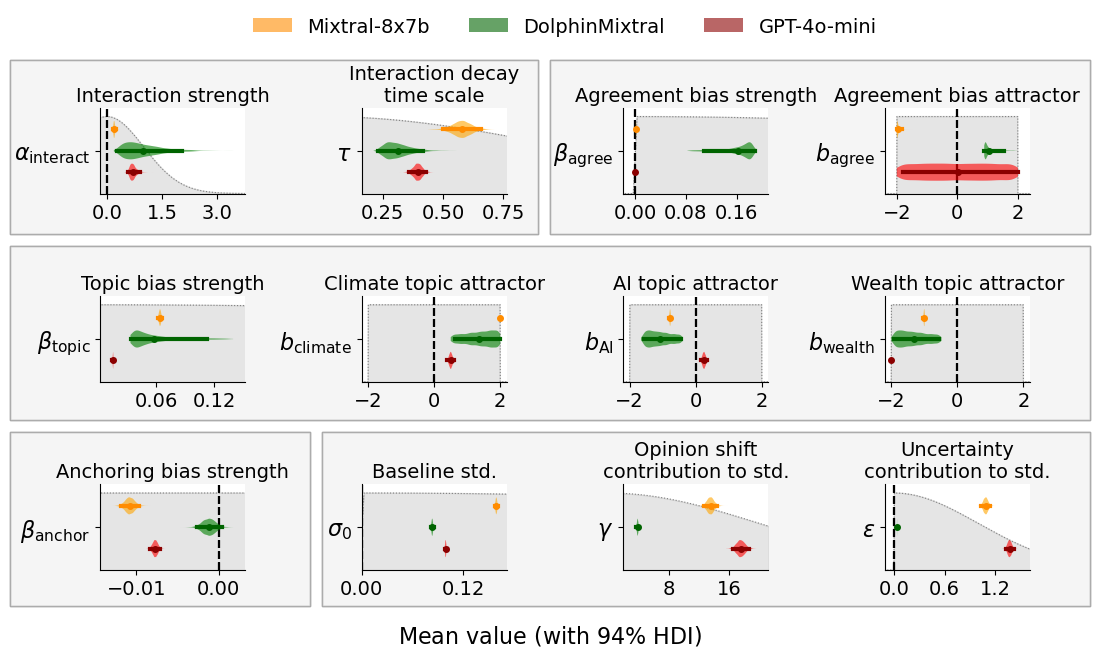

In [ ]:
prior_pdfs = {
    "alpha": lambda x: stats.norm.pdf(x, 0, 1),
    "tau":            lambda x: stats.halfnorm.pdf(x, scale=1),
    "beta_t":     lambda x: stats.norm.pdf(x, 0, 1),
    "b0":        lambda x: stats.uniform.pdf(x, loc=-2, scale=4),
    "b1":        lambda x: stats.uniform.pdf(x, loc=-2, scale=4),
    "b2":        lambda x: stats.uniform.pdf(x, loc=-2, scale=4),
    "beta_a":     lambda x: stats.halfnorm.pdf(x, scale=1),
    "a":        lambda x: stats.uniform.pdf(x, loc=-2, scale=4),
    "beta_c":    lambda x: stats.norm.pdf(x, 0, 1),
    "sigma0":         lambda x: stats.halfnorm.pdf(x, scale=1),
    "gamma":          lambda x: stats.halfnorm.pdf(x, scale=20),
    "eps":            lambda x: stats.halfnorm.pdf(x, scale=1),
}

# Color settings
violin_colors = {"mixtral": "orange", "dm": "green", "gpt": "red"}
hdi_colors    = {"mixtral": "darkorange", "dm": "darkgreen", "gpt": "darkred"}

# Y‑positions: one group per parameter
base_y = np.linspace(0, 12, 12)[::-1]  # beta bottom, alpha top
offsets = {"mixtral": +0.25, "dm": 0.0, "gpt": -0.25}

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 6), sharex=False)
fig.subplots_adjust(hspace=1.2, wspace=0.8)

axes_flat = axes.ravel()

for p_idx, (param, ax) in enumerate(zip(params, axes_flat)):
    all_draws = np.concatenate([posterior[llm][param] for llm in llms])       
    x_min, x_max = all_draws.min(), all_draws.max()                           
    pad        = 0.1 * (x_max - x_min)                                         
    x_grid     = np.linspace(-30, 30, 10**4)                  

    style = 'solid'
    av = 0.1
    rect1 = patches.Rectangle((0.05, 0.67), 0.44, 0.29,
                          transform=fig.transFigure, linestyle=style,
                          linewidth=1, edgecolor='grey', alpha=av,facecolor='whitesmoke', zorder=-100)
    fig.patches.append(rect1)

    rect5 = patches.Rectangle((0.5, 0.67), 0.45, 0.29,
                          transform=fig.transFigure, linestyle=style,
                          linewidth=1, edgecolor='grey', alpha=av,facecolor='whitesmoke', zorder=-100)
    fig.patches.append(rect5)


    rect2 = patches.Rectangle((0.05, 0.36), 0.9, 0.29,
                          transform=fig.transFigure, linestyle=style,
                          linewidth=1, edgecolor='grey', alpha=av,facecolor='whitesmoke', zorder=-100)
    fig.patches.append(rect2)

    rect3 = patches.Rectangle((0.05, 0.05), 0.25, 0.29,
                          transform=fig.transFigure, linestyle=style,
                          linewidth=1, edgecolor='grey', alpha=av,facecolor='whitesmoke', zorder=-100)
    fig.patches.append(rect3)

    rect4 = patches.Rectangle((0.31, 0.05), 0.64, 0.29,
                          transform=fig.transFigure, linestyle=style,
                          linewidth=1, edgecolor='grey', alpha=av,facecolor='whitesmoke', zorder=-100)
    fig.patches.append(rect4)

    for llm in llms:
        draws = posterior[llm][param]
        y_pos = offsets[llm]
        
        # Violin
        parts = ax.violinplot(draws, positions=[y_pos], vert=False,
                              widths=0.2, showmeans=False, showextrema=False,
                              showmedians=False)
        parts["bodies"][0].set_facecolor(violin_colors[llm])
        parts["bodies"][0].set_edgecolor("none")
        parts["bodies"][0].set_alpha(0.6)
        
        # HDI & mean
        hdi_low, hdi_high = az.hdi(draws, hdi_prob=0.95)
        mean = draws.mean()
        ax.plot([hdi_low, hdi_high], [y_pos, y_pos], color=hdi_colors[llm], lw=3)
        ax.plot(mean, y_pos, marker="o", color=hdi_colors[llm], markersize=4)
        ax.set_yticks([0])
        ax.set_yticklabels([param_labels[p_idx]])
        ax.spines[["top", "right"]].set_visible(False)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=16)    
        ax.axvline(0, linestyle="--", color="black", zorder=-2, lw=1.5)
        ax.set_title(param_titles[p_idx], fontsize=14, loc="center", pad=5)


    # --- prior curve (grey, dotted) ---      
    pdf        = prior_pdfs[param](x_grid)                                     
    pdf_scaled = pdf / pdf.max()  * 0.9  -0.5                                  
    ax.plot(x_grid,
            pdf_scaled,
            ls=':', color='grey', zorder=-3, lw=0.8)                                
    ax.fill_between(
        x_grid,
        min(offsets.values()) - 0.5,                 # baseline
        pdf_scaled ,    # curve
        color="grey", alpha=0.2, zorder=-4)          # translucent grey fill
    ax.set_ylim([-0.5,0.5])

    if p_idx > 4 and p_idx < 8:
        ax.set_xlim([-2.2,2.2])
        ax.set_xticks([-2, 0, 2])

    else:
        ax.xaxis.set_major_locator(MaxNLocator(3))
        ax.set_xlim(x_min - pad, x_max + pad)                                       


    
axes_flat[-4].set_xticks([-0.01,0] )
axes_flat[-3].set_xticks([0, 0.12] )

axes_flat[0].plot


# Legend
handles = [Patch(facecolor=hdi_colors[llm], edgecolor="none",
                 alpha=0.6, label=llm_labels[i]) for i, llm in enumerate(llms)]
axes_flat[0].legend(handles=handles, frameon=False, fontsize=14, loc=(1, 1.75), ncols=3)

fig.supxlabel(r"Mean value (with $94\%$ HDI)", fontsize=16, y=-0.02)

plt.savefig("../../plots/figure_4", dpi=400, bbox_inches='tight')
plt.show()